In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('C:/Users/maslo/Desktop/karpov_start_ml/2_module/13_lesson/materials/processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

pipe_lr = Pipeline([('scaler', MinMaxScaler()), ('classification', LogisticRegression())])
pipe_lr.fit(X_train, y_train)

pipe_svm = Pipeline([('scaler', MinMaxScaler()), ('classification', LinearSVC())])
pipe_svm.fit(X_train, y_train)



Pipeline(steps=[('scaler', MinMaxScaler()), ('classification', LinearSVC())])

In [6]:
pipe_lr.score(X_test, y_test)

0.8427326914259514

In [7]:
pipe_svm.score(X_test, y_test)

0.84039848276437

Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay

AUC ROC = 0.6891019116156428
AUC ROC = 0.6891019116156428


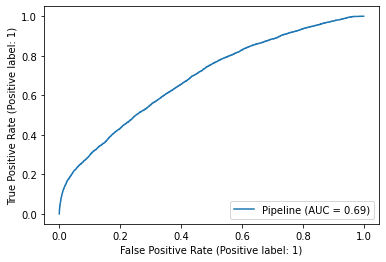

In [15]:
### С изображением рок-кривой для ЛогРега не будет проблем:
tpr, fpr, thresholds  = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:,1])
print('AUC ROC =', auc(tpr, fpr))
print('AUC ROC =', roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:,1]))
RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test)

In [45]:
decisions = pd.DataFrame(pipe_svm.decision_function(X_test), columns=['decision'])

In [46]:
neg_max = decisions[decisions['decision'] < 0].min()

In [47]:
pos_max = decisions[decisions['decision'] > 0].max()

In [50]:
calibrated_svm_test_probas = np.array([
    abs((value - neg_max) * 0.5 / neg_max) if value < 0 else abs(value * 0.5 / pos_max) + 0.5 \
    for value in decisions.values
])

AUC ROC = 0.6877920339824999
AUC ROC = 0.6877920339824999


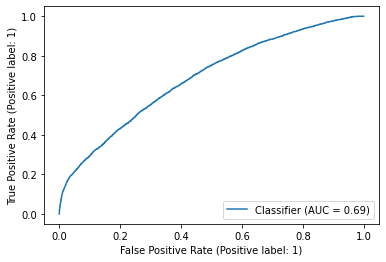

In [51]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function
tpr, fpr, thresholds  = roc_curve(y_test, calibrated_svm_test_probas)
print('AUC ROC =', auc(tpr, fpr))
print('AUC ROC =', roc_auc_score(y_test, calibrated_svm_test_probas))
RocCurveDisplay.from_predictions(y_test, calibrated_svm_test_probas)

Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

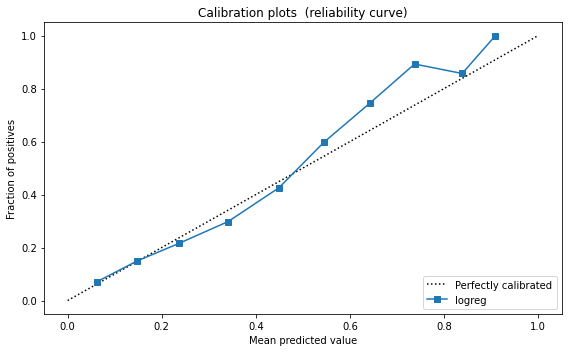

In [52]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
prob_pos = pipe_lr.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()

In [63]:
from sklearn.calibration import CalibrationDisplay

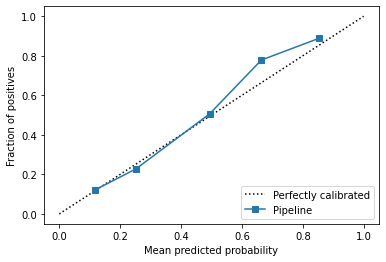

In [67]:
CalibrationDisplay.from_estimator(pipe_lr, X_test, y_test)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D28436C448>]],
      dtype=object)

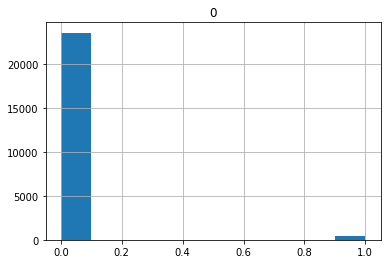

In [59]:
pd.DataFrame(pipe_svm.predict(X_test)).hist()

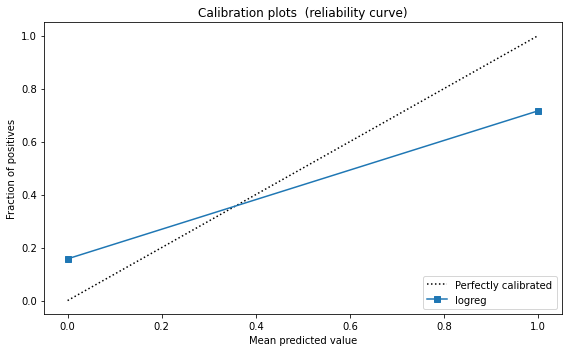

In [60]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
prob_pos = pipe_svm.predict(X_test)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()


**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

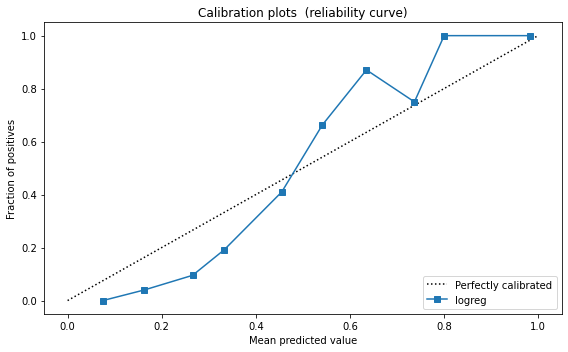

In [61]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
prob_pos = calibrated_svm_test_probas
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()



In [68]:
pipe_svm.decision_function(X_test)

array([-0.55389901, -0.67142301, -0.74559755, ..., -0.7669298 ,
       -0.60068044, -0.77822453])

In [69]:
def sigmoid(out):
    return 1 / (1 + np.exp(-out))

In [71]:
sigmoid(pipe_svm.decision_function(X_test))

array([0.36496028, 0.33817828, 0.32178133, ..., 0.31714363, 0.35418804,
       0.31470267])

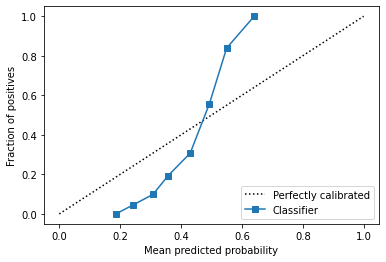

In [73]:
CalibrationDisplay.from_predictions(y_test, sigmoid(pipe_svm.decision_function(X_test)), n_bins=15)

In [75]:
from sklearn.calibration import CalibratedClassifierCV

In [76]:
calibration = CalibratedClassifierCV(pipe_svm, cv=5, method='sigmoid')

In [77]:
calibration.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('scaler',
                                                       MinMaxScaler()),
                                                      ('classification',
                                                       LinearSVC())]),
                       cv=5)

In [78]:
calibration.predict_proba(X_test)[:, 1]

array([0.19971226, 0.14673161, 0.11986856, ..., 0.11302188, 0.17690765,
       0.10944434])

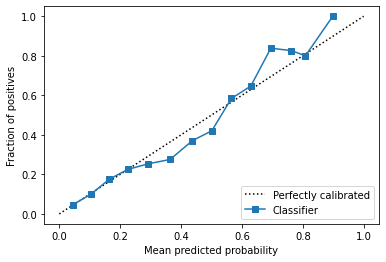

In [79]:
CalibrationDisplay.from_predictions(y_test, calibration.predict_proba(X_test)[:, 1], n_bins=15)

In [80]:
calibration = CalibratedClassifierCV(pipe_svm, cv=5, method='isotonic')

In [81]:
calibration.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('scaler',
                                                       MinMaxScaler()),
                                                      ('classification',
                                                       LinearSVC())]),
                       cv=5, method='isotonic')

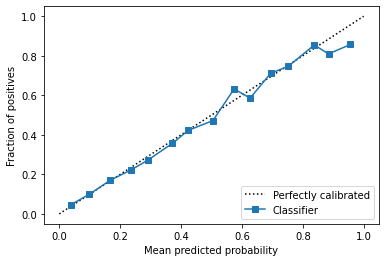

In [82]:
CalibrationDisplay.from_predictions(y_test, calibration.predict_proba(X_test)[:, 1], n_bins=15)